In [ ]:
import os
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import pickle
import numpy as np
import wandb
import pandas as pd 
from pprint import pprint
from copy import deepcopy
from dataclasses import dataclass, field
import matplotlib
import matplotlib.pyplot as plt
import re
import torch
from numpy.linalg import svd

In [2]:
def get_empirical_rank(input_matrix, singular_matrix, thres) -> int:
    
    empirical_rank = 0
    accum_var = 0
    total_var = torch.norm(input_matrix, p="fro").pow(2).item()
    
    while accum_var < thres * total_var:
        accum_var += singular_matrix[empirical_rank].pow(2).item()
        empirical_rank += 1

    return empirical_rank

def compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft) -> list:

    cos_sim_list1 = []
    cos_sim_list2 = []

    W_pt = (W_pt-W_pt.mean())/W_pt.std() # Try normailization
    U_pt, S_pt, V_pt_T = torch.svd(W_pt)
    rank_W_pre = get_empirical_rank(W_pt, S_pt, thres = rank_threshold_pt)
    # rank_W_pre = torch.linalg.matrix_rank(W_pre, rtol=0.3)
    Proj_pre = torch.mm(U_pt[:,:rank_W_pre],U_pt[:,:rank_W_pre].T)

    W_ft = (W_ft-W_ft.mean())/W_ft.std() # Try normailization
    U_ft, S_ft, V_ft_T = torch.svd(W_ft)
    rank_Delta_W = get_empirical_rank(W_ft, S_ft, thres = rank_threshold_ft)
    Proj_Delta = torch.mm(U_ft[:,:rank_Delta_W],U_ft[:,:rank_Delta_W].T)
    # print('Rank of W_pt = {}, Rank of W_ft = {}'.format(rank_W_pre, rank_Delta_W))

    # # TODO: Method 1: proj latter matrix to the former
    for rank_i in range(rank_Delta_W):
        proj_vec1 = torch.mm(Proj_pre,U_ft[:,rank_i:rank_i+1])
        cos_sim1 = torch.cosine_similarity(proj_vec1.flatten().unsqueeze(0), U_ft[:,rank_i:rank_i+1].flatten().unsqueeze(0))
        cos_sim_list1.append(cos_sim1.item())

    # TODO: Method 2: proj former matrix to the latter
    for rank_i in range(rank_W_pre):
        proj_vec2 = torch.mm(Proj_Delta,U_pt[:,rank_i:rank_i+1])
        cos_sim2 = torch.cosine_similarity(proj_vec2.flatten().unsqueeze(0), U_pt[:,rank_i:rank_i+1].flatten().unsqueeze(0))
        cos_sim_list2.append(cos_sim2.item())
    
    cos_sim_list1 = sorted(cos_sim_list1)
    theta_list1 = np.arccos(cos_sim_list1)*180/np.pi
    # sine_list = np.sin(theta_list/180*np.pi)
    # cos_sim_list2 = sorted(cos_sim_list2)
    # theta_list2 = np.arccos(cos_sim_list2)*180/np.pi

    print('L2F: Max = {:.2f}; Q3 = {:.2f}; Q2 = {:.2f}; Q1 = {:.2f}; Min = {:.2f}'.format(np.max(theta_list1), 
                                                                                        np.percentile(theta_list1,75), 
                                                                                        # np.mean(theta_list1), 
                                                                                        np.percentile(theta_list1,50), 
                                                                                        np.percentile(theta_list1,25),
                                                                                        np.min(theta_list1)))
    # print('F2L: Max = {:.2f}; Q3 = {:.2f}; Q2 = {:.2f}; Q1 = {:.2f}; Min = {:.2f}'.format(np.max(theta_list2), 
    #                                                                                     np.percentile(theta_list2,75), 
    #                                                                                     # np.mean(theta_list1), 
    #                                                                                     np.percentile(theta_list2,50), 
    #                                                                                     np.percentile(theta_list2,25),
    #                                                                                     np.min(theta_list2)))

    return theta_list1
    # return sine_list

    

In [ ]:

rank_threshold_pt = 0.99
rank_threshold_ft = 0.99

backbone = 'EleutherAI/pythia-160m-deduped'

pt_ckpt_1, pt_ckpt_2 = 'checkpoint-8000', 'checkpoint-72000'
ft_ckpt_1, ft_ckpt_2 = 'checkpoint-6250', 'checkpoint-62500'
ft_ckpt_first200steps_1, ft_ckpt_first200steps_2 = 'checkpoint-100', 'checkpoint-150'

# exp_id_list = ['SEQ', 'REPLAY020']
exp_id_list = ['SEQ']

EXP_ckpt_dict = {
    'SEQ': {
        # 'pt<->pt': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_1}',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',  
        # },

        # 'pt<->qa_task0': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',  
        # },
        
        # 'pt<->qa_task1': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/{ft_ckpt_2}',  
        # },

        # 'qa_task0<->qa_task1': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/{ft_ckpt_2}',  
        # },

        # 'qa_task0<->qa_task1_first200steps': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_1}',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_2}',  
        # },

        # 'qa_task1_first200steps<->qa_task1': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_1}',  
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_2}',  
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/{ft_ckpt_2}',  
        # },

        'qa_task1_first200steps<->qa_task1_after200steps': {
            'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_1}',  
            'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_2}',  
            'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1_first_200steps_eval_every_step/{ft_ckpt_first200steps_2}',  
            'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/1_1/{ft_ckpt_2}',  
        },
    },

    'REPLAY020': {
        # 'pt<->pt': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_1}',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',  
        # },

        # 'pt<->qa_task0': {
        #     'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',
        #     'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
        #     'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',  
        #     'path_ft_2' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',  
        # },
        
        'pt<->qa_task1': {
            'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/{pt_ckpt_2}',
            'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
            'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
            'path_ft_2' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_23',  
        },

        'qa_task0<->qa_task1': {
            'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
            'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',
            'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
            'path_ft_2' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_23',  
        },

        'qa_task0<->qa_task1_first200steps': {
            'path_pretrained_1' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/final_model',
            'path_pretrained_2' :   f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/{ft_ckpt_2}',
            'path_ft_1' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_99',  
            'path_ft_2' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_149',  
        },

        'qa_task1_first200steps<->qa_task1': {
            'path_pretrained_1' :   f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_99',  
            'path_pretrained_2' :   f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_149',  
            'path_ft_1' :           f'/dev_data/zjh/physics-of-forgetting-in-llm/physics_of_forgetting/model/gpt-neox/processed_0720_v0730/config_v0806/multi5_permute_fullname/task_0/fine_tuning/0_0/final_model',  
            'path_ft_2' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_23',  
        },

        'qa_task1_first200steps<->qa_task1_after200steps': {
            'path_pretrained_1' :   f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_99',  
            'path_pretrained_2' :   f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_149',  
            'path_ft_1' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-09-15-23-53/checkpoint_llm_task_1_epoch_0_step_149',  
            'path_ft_2' :           f'/dev_data/zjh/LLM_CL/experiments/SOTA-pythia-160m-bio-finetune_task0-saveckpt-REPLAY_0/2024-09-08-23-10-46/checkpoint_llm_task_1_epoch_23',  
        },
    }
}

is_save_all = True

EXP_sine_value_component_dict = {}
    
sine_value_dir = os.path.abspath('.')


for exp_id in exp_id_list:

    sine_value_component_list = []

    sine_value_file = f'sine_value_each_component_{exp_id}_L2F.pkl'

    if not os.path.isfile(os.path.join(sine_value_dir,sine_value_file)):

        path_dict = EXP_ckpt_dict[exp_id]

        for group in path_dict.keys():
            
            if is_save_all:
                sine_value_all_dict = {}
                sine_value_all_file = f'sine_value_all_{exp_id}_{group}_L2F.pkl'

            path_pretrained_1, path_pretrained_2 = path_dict[group]['path_pretrained_1'], path_dict[group]['path_pretrained_2']
            path_ft_1, path_ft_2 = path_dict[group]['path_ft_1'], path_dict[group]['path_ft_2']

            tokenizer = AutoTokenizer.from_pretrained(backbone)

            config_pt_1 = AutoConfig.from_pretrained(path_pretrained_1)
            model_pretrained_1 = AutoModelForCausalLM.from_pretrained(path_pretrained_1, config=config_pt_1)  # get the pre-trained model
            if path_pretrained_2 is not None:
                config_pt_2 = AutoConfig.from_pretrained(path_pretrained_2)
                model_pretrained_2 = AutoModelForCausalLM.from_pretrained(path_pretrained_2, config=config_pt_2)  # get the pre-trained model
            else:
                model_pretrained_2 = model_pretrained_1 # Placeholder for the loop

            config_ft_1 = AutoConfig.from_pretrained(path_ft_1)
            config_ft_2 = AutoConfig.from_pretrained(path_ft_2)
            model_ft_1 = AutoModelForCausalLM.from_pretrained(path_ft_1, config=config_ft_1)  # ge the model that is fine-tuned on task1 for several steps (currently 19 steps)
            model_ft_2 = AutoModelForCausalLM.from_pretrained(path_ft_2, config=config_ft_2)  # ge the model that is fine-tuned on task1 for several steps (currently 19 steps)


            for (n1,p1), (n2,p2), (n3,p3), (n4,p4) in zip(model_pretrained_1.named_parameters(), 
                                                model_pretrained_2.named_parameters(),
                                                model_ft_1.named_parameters(),
                                                model_ft_2.named_parameters()):
                
                assert n1 == n2 and n2 == n3 and n3 == n4

                if path_pretrained_2 is not None:
                    W_pt = p2.data - p1.data
                else:
                    W_pt = p1.data
                W_ft = p4.data - p3.data
                
                if n1 == 'gpt_neox.embed_in.weight':
                    print('='*12 + ' Embedding Input ' + '='*12)
                    W_pt, W_ft = W_pt.T, W_ft.T
                    sine_list = compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft)
                    for sine_value in sine_list:
                        sine_value_component_list.append([-1,'embed_layer',sine_value,group])
                    if is_save_all:
                        sine_value_all_dict[n1] = np.mean(sine_list)
                    print('='*40)

                for layer_id in range(12):

                    if n1 == f'gpt_neox.layers.{layer_id}.mlp.dense_4h_to_h.weight': 
                        
                        print(f'----- {layer_id}.mlp.dense_4h_to_h -----')
                        sine_list = compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft)
                        for sine_value in sine_list:
                            sine_value_component_list.append([layer_id,'dense_4h_to_h',sine_value,group])
                        if is_save_all:
                            sine_value_all_dict[n1] = np.mean(sine_list)
                        print('='*40)
                        
                    elif n1 == f'gpt_neox.layers.{layer_id}.mlp.dense_h_to_4h.weight': 
                        print(f'----- {layer_id}.mlp.dense_h_to_4h -----')
                        W_pt, W_ft = W_pt.T, W_ft.T
                        sine_list = compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft)
                        for sine_value in sine_list:
                            sine_value_component_list.append([layer_id,'dense_h_to_4h',sine_value,group])
                        if is_save_all:
                            sine_value_all_dict[n1] = np.mean(sine_list)

                    elif n1 == f'gpt_neox.layers.{layer_id}.attention.dense.weight': 
                        print(f'----- {layer_id}.attention.dense -----')
                        sine_list = compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft)
                        for sine_value in sine_list:
                            sine_value_component_list.append([layer_id,'attention_dense',sine_value,group])
                        if is_save_all:
                            sine_value_all_dict[n1] = np.mean(sine_list)

                    elif n1 == f'gpt_neox.layers.{layer_id}.attention.query_key_value.weight': 
                        print('='*15 + f' Layer {layer_id} ' + '='*15)
                        print(f'----- {layer_id}.attention.query_key_value -----')
                        # NOTE: The shape of attention.query_key_value is (768*3) * 768, 
                        # corresponds to query, key, value projection matrix
                        assert W_pt.shape == W_ft.shape and W_pt.shape == (768*3,768), 'The shape must be (768*3,768)'
                        for j, component_name in enumerate(['query','key','value']):
                            sub_W_pt, sub_W_ft = W_pt[768*j:768*(j+1),:], W_ft[768*j:768*(j+1),:]
                            sine_list = compute_sine_between_matrices(sub_W_pt, sub_W_ft, rank_threshold_pt, rank_threshold_ft)
                            for sine_value in sine_list:
                                sine_value_component_list.append([layer_id,f'attention_{component_name}',sine_value,group])
                            if is_save_all:
                                sine_value_all_dict[n1] = np.mean(sine_list)

                if n1 == 'embed_out.weight':
                    print('='*12 + ' Embedding Output ' + '='*12)
                    W_pt, W_ft = W_pt.T, W_ft.T
                    sine_list = compute_sine_between_matrices(W_pt, W_ft, rank_threshold_pt, rank_threshold_ft)
                    for sine_value in sine_list:
                        sine_value_component_list.append([12,'embed_layer',sine_value,group])
                    if is_save_all:
                        sine_value_all_dict[n1] = np.mean(sine_list)
                    print('='*40)

            with open(os.path.join(sine_value_dir, sine_value_all_file),'wb') as f:
                pickle.dump(sine_value_all_dict, f)
            print(f'Saving sine values dict (all) to {os.path.join(sine_value_dir, sine_value_all_file)} ...')
            
            
        with open(os.path.join(sine_value_dir, sine_value_file),'wb') as f:
            pickle.dump(sine_value_component_list, f)
        print(f'Saving sine values to {os.path.join(sine_value_dir, sine_value_file)} ...')



    with open(os.path.join(sine_value_dir, sine_value_file),'rb') as f:
        sine_value_component_list = pickle.load(f)
    EXP_sine_value_component_dict[exp_id] = sine_value_component_list

    print(f'Loading sine values from {os.path.join(sine_value_dir, sine_value_file)} ...')
            

ExpID = SEQ


<Figure size 640x480 with 0 Axes>

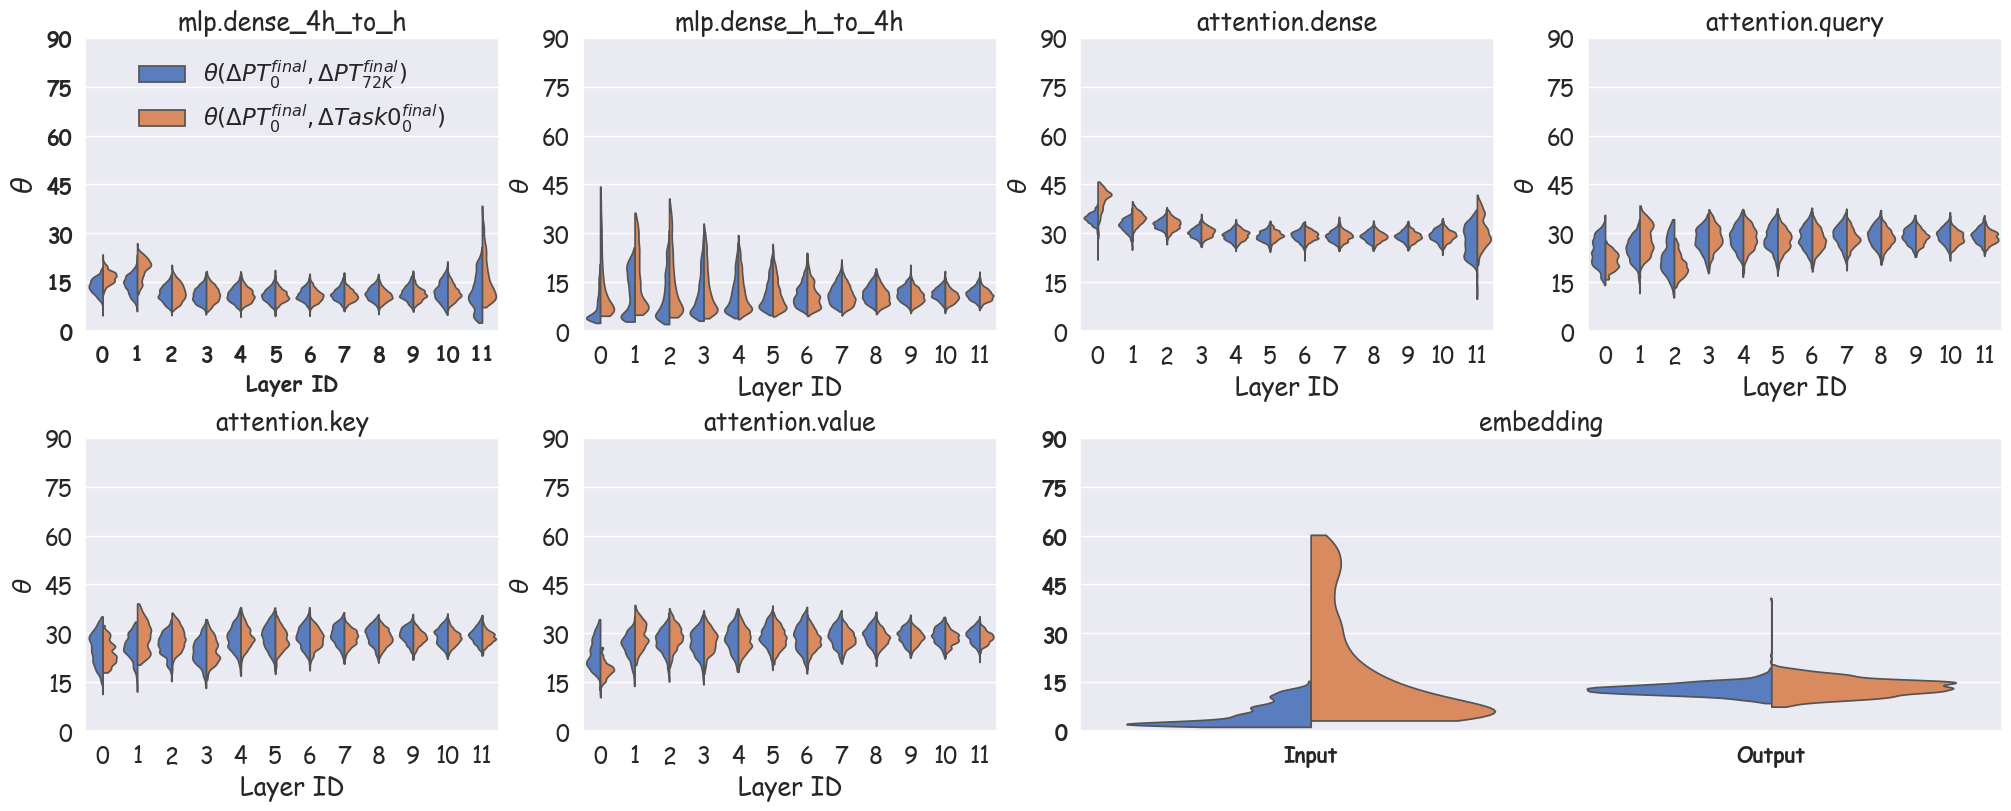

<Figure size 640x480 with 0 Axes>

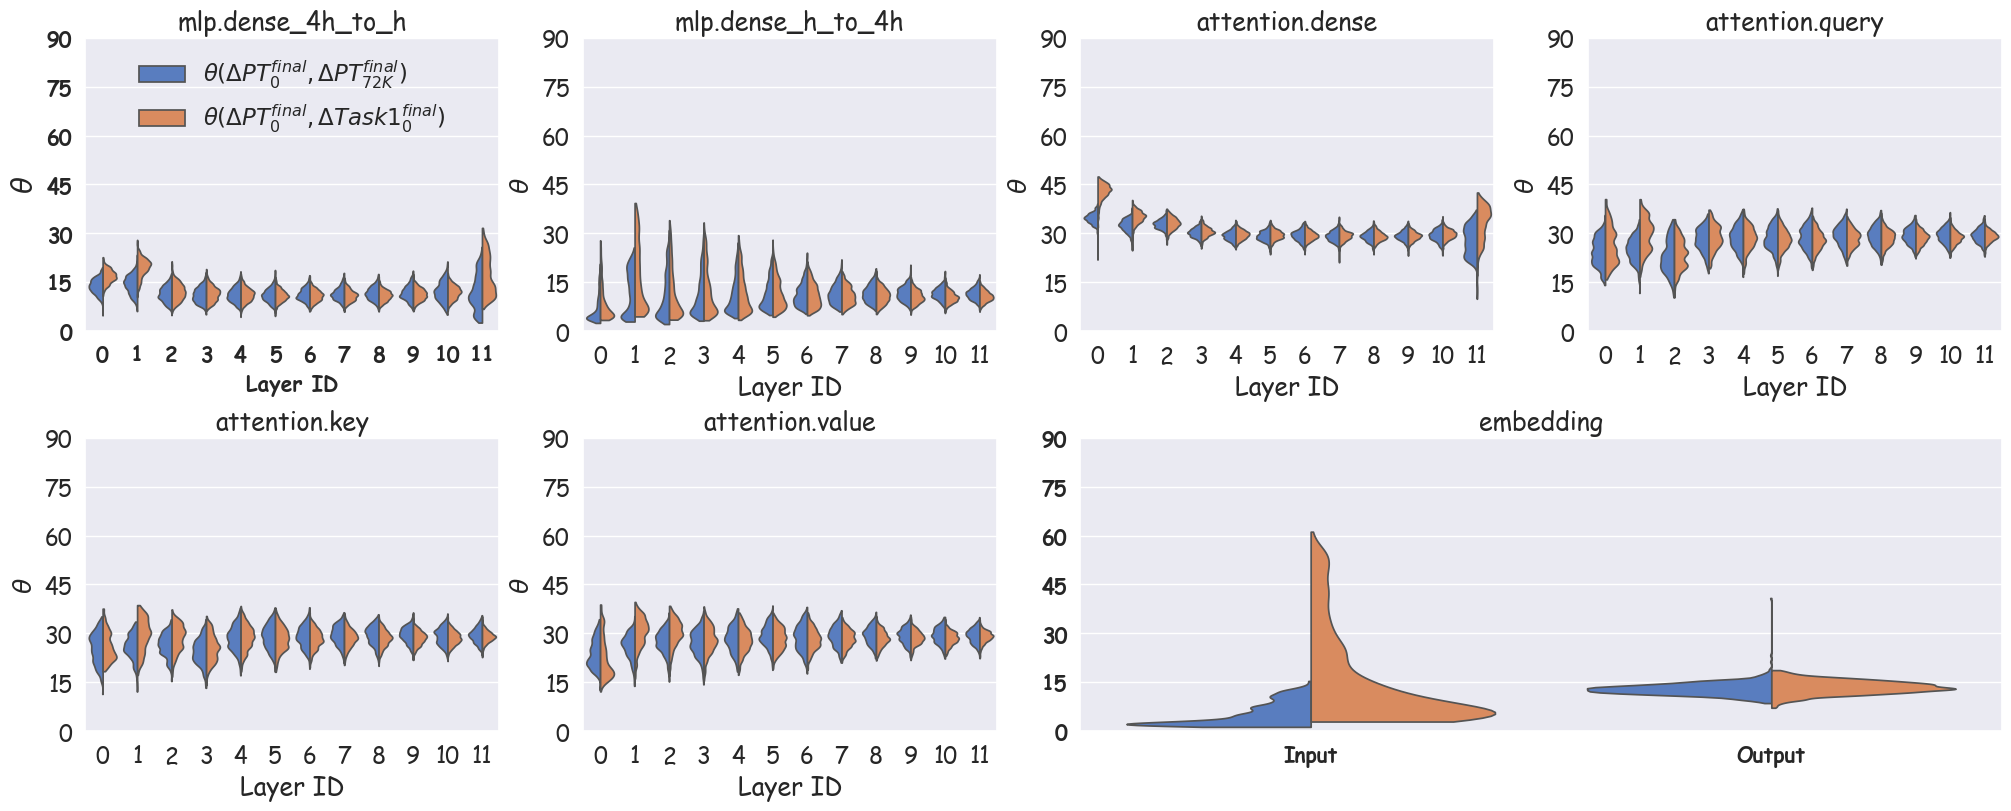

<Figure size 640x480 with 0 Axes>

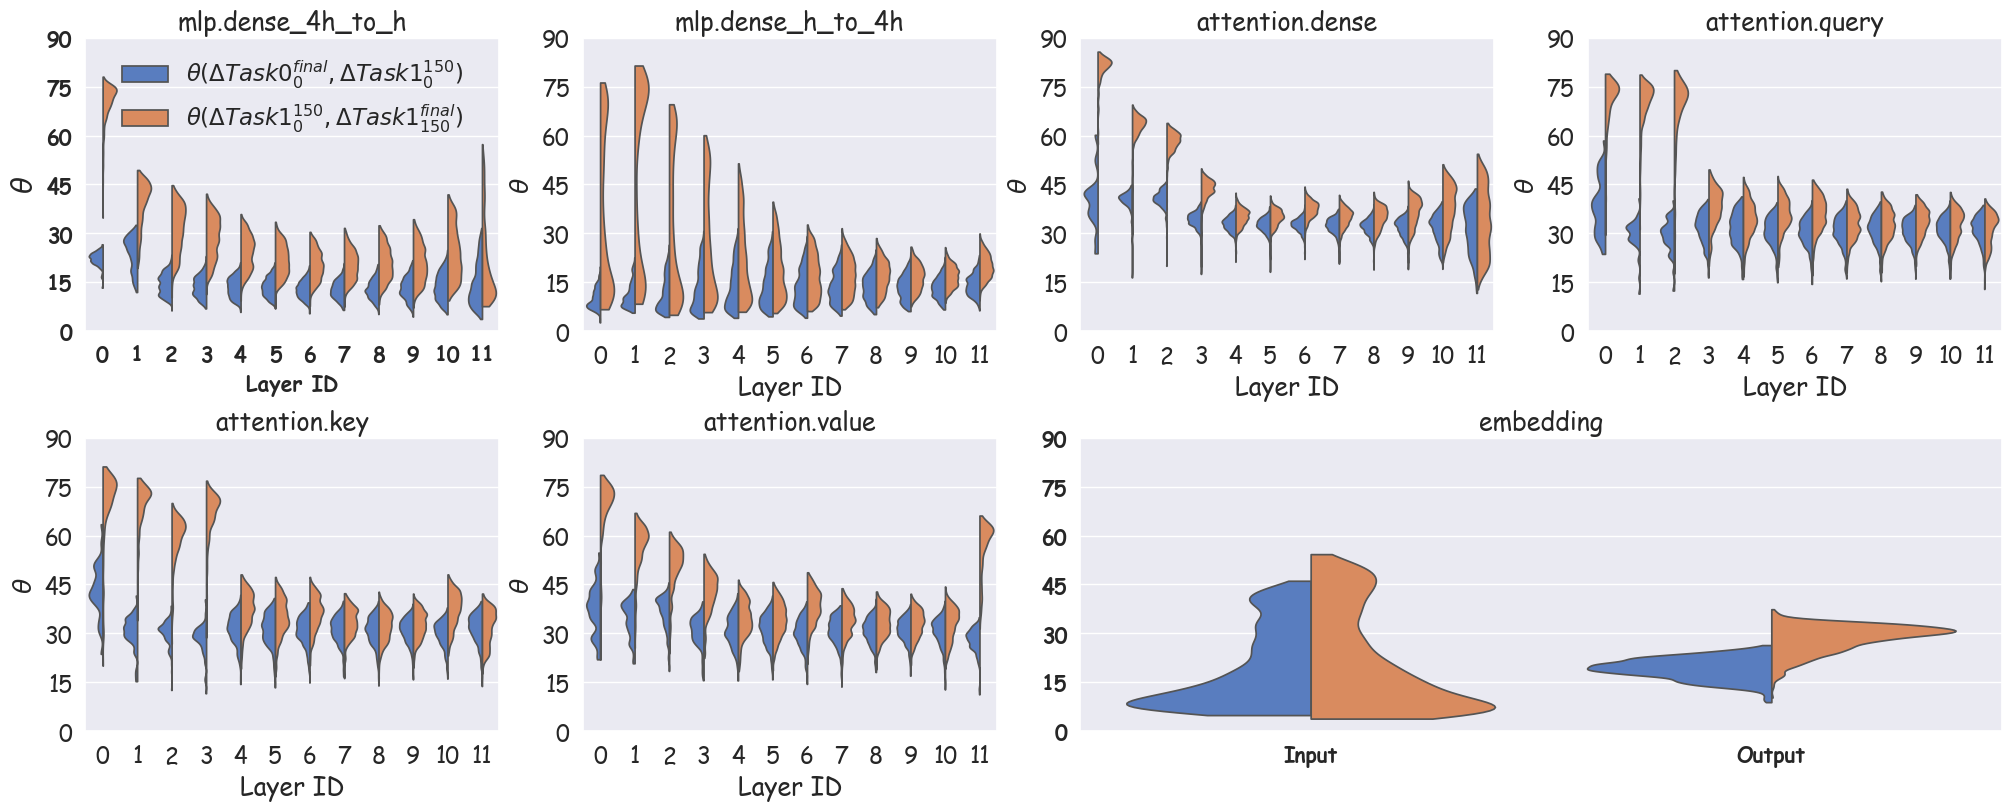

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

group2legend = {
    "pt<->pt" : "$\\theta(\\Delta PT_{0}^{final},\\Delta PT_{72K}^{final})$",
    "pt<->qa_task0" : "$\\theta(\\Delta PT_{0}^{final},\\Delta Task0_{0}^{final})$",
    "pt<->qa_task1" : "$\\theta(\\Delta PT_{0}^{final},\\Delta Task1_{0}^{final})$",
    "qa_task0<->qa_task1_first200steps" : "$\\theta(\\Delta Task0_{0}^{final},\\Delta Task1_{0}^{150})$",
    "qa_task0<->qa_task1" : "$\\theta(\\Delta Task0_{0}^{final},\\Delta Task1_{0}^{final})$",
    "qa_task1_first200steps<->qa_task1" : "$\\theta(\\Delta Task1_{0}^{150},\\Delta Task1_{0}^{final})$",
    "qa_task1_first200steps<->qa_task1_after200steps": "$\\theta(\\Delta Task1_{0}^{150},\\Delta Task1_{150}^{final})$",
}


query_pattern = "group == '{0}' or group == '{1}'"
query_list = [
    # 1. Gap between Pretraining and Finetuning (Task 0) : Input Embedding
    ('pt<->pt','pt<->qa_task0'),

    # 2. Gap between Pretraining and Finetuning (Task 1) : Input Embedding
    ('pt<->pt','pt<->qa_task1'),

    # 3. Gap between task 1 (first 200 steps) and task 1 : Input Embedding + MLP in the first layers
    ('qa_task0<->qa_task1_first200steps','qa_task1_first200steps<->qa_task1_after200steps'),
    # ('qa_task0<->qa_task1_first200steps','qa_task1_first200steps<->qa_task1'),
]

for exp_id in exp_id_list:

    print(f'ExpID = {exp_id}')
    
    data = pd.DataFrame(EXP_sine_value_component_dict[exp_id],columns=['layer','component','theta','group'])
    data['group_legend'] = data['group'].map(lambda x: group2legend[x])

    # for plot_type in ['main','full']:
    for plot_type in ['full']:
        
        for name1, name2 in query_list:

            data_filtered = data.query(query_pattern.format(name1,name2))

            sns.set_theme(style="white",font='Comic Sans MS', palette=None)
            plt.clf()
            
            if plot_type == 'main':
                plt.figure(constrained_layout=True,figsize=(8,3.5))
            else:
                plt.figure(constrained_layout=True,figsize=(20, 8))
            sns.set_theme(style="darkgrid",font='Comic Sans MS', font_scale=1.5)
            plt.rcParams['font.sans-serif'] = 'Comic Sans MS'

            is_split = True
            
            if plot_type == 'main':
                plt.subplot(1,4,(1,3)) 
            else:
                plt.subplot(2,4,1) 
            data_dense_4h_to_h = data_filtered.query("component == 'dense_4h_to_h'")

            ax = sns.violinplot(x="layer", y="theta", 
                                hue="group_legend",
                                data=data_dense_4h_to_h, palette="muted",
                                split=is_split, 
                                inner=None,
                                density_norm="width",
                                bw_method=0.2,
                                cut=0,
                                )
            sns.move_legend(
                ax, 'upper center',
                bbox_to_anchor=(.5, 1), title=None, frameon=False,
            )
            plt.xlabel('Layer ID',fontsize=15,fontweight='bold')
            plt.ylabel("$\\theta$",fontsize=20,fontweight='bold')
            plt.xticks(fontsize=15,fontweight='bold')
            plt.yticks(ticks=list(range(0,105,15)),fontsize=15,fontweight='bold')
            plt.ylim(bottom=0,top=90)
            plt.title('mlp.dense_4h_to_h')

            if plot_type == 'main':
                pass
            else:
                plt.subplot(2,4,2) 
                
                data_dense_h_to_4h = data_filtered.query("component == 'dense_h_to_4h'")
                ax = sns.violinplot(x="layer", y="theta", 
                                    hue="group_legend",
                                    data=data_dense_h_to_4h, palette="muted",
                                    split=is_split,
                                    inner=None,
                                    density_norm="width",
                                    bw_method=0.2,
                                    cut=0,
                                    )
                plt.legend([],[],frameon=False)
                plt.xlabel('Layer ID')
                plt.ylabel("$\\theta$")
                plt.yticks(ticks=list(range(0,105,15)))
                plt.ylim(bottom=0,top=90)
                plt.title('mlp.dense_h_to_4h')
            
            if plot_type == 'main':
                pass
            else:
                plt.subplot(2,4,3)
                
                data_attention_dense = data_filtered.query("component == 'attention_dense'")
                ax = sns.violinplot(x="layer", y="theta", 
                                    hue="group_legend",
                                    data=data_attention_dense, palette="muted",
                                    split=is_split,
                                    inner=None,
                                    density_norm="width",
                                    bw_method=0.2,
                                    cut=0,
                                    )
                plt.legend([],[],frameon=False)
                plt.xlabel('Layer ID')
                plt.ylabel("$\\theta$")
                plt.yticks(ticks=list(range(0,105,15)))
                plt.ylim(bottom=0,top=90)
                plt.title('attention.dense')

            if plot_type == 'full':
                plt.subplot(2,4,4)
                data_attention_dense = data_filtered.query("component == 'attention_query'")
                ax = sns.violinplot(x="layer", y="theta", 
                                    hue="group_legend",
                                    data=data_attention_dense, palette="muted",
                                    split=is_split,
                                    inner=None,
                                    density_norm="width",
                                    bw_method=0.2,
                                    cut=0,
                                    )
                plt.legend([],[],frameon=False)
                plt.xlabel('Layer ID')
                plt.ylabel("$\\theta$")
                plt.yticks(ticks=list(range(0,105,15)))
                plt.ylim(bottom=0,top=90)
                plt.title('attention.query')

                plt.subplot(2,4,5)
                data_attention_dense = data_filtered.query("component == 'attention_key'")
                ax = sns.violinplot(x="layer", y="theta", 
                                    hue="group_legend",
                                    data=data_attention_dense, palette="muted",
                                    split=is_split,
                                    inner=None,
                                    density_norm="width",
                                    bw_method=0.2,
                                    cut=0,
                                    )
                plt.legend([],[],frameon=False)
                plt.xlabel('Layer ID')
                plt.ylabel("$\\theta$")
                plt.yticks(ticks=list(range(0,105,15)))
                plt.ylim(bottom=0,top=90)
                plt.title('attention.key')

                plt.subplot(2,4,6)
                data_attention_dense = data_filtered.query("component == 'attention_value'")
                ax = sns.violinplot(x="layer", y="theta", 
                                    hue="group_legend",
                                    data=data_attention_dense, palette="muted",
                                    split=is_split,
                                    inner=None,
                                    density_norm="width",
                                    bw_method=0.2,
                                    cut=0,
                                    )
                plt.legend([],[],frameon=False)
                plt.xlabel('Layer ID')
                plt.ylabel("$\\theta$")
                plt.yticks(ticks=list(range(0,105,15)))
                plt.ylim(bottom=0,top=90)
                plt.title('attention.value')

            if plot_type == 'main':
                plt.subplot(1,4, 4)
            else:
                plt.subplot(2,4,(7,8))
            data_attention_dense = data_filtered.query("component == 'embed_layer'")
            ax = sns.violinplot(x="layer", y="theta", 
                                hue="group_legend",
                                data=data_attention_dense, palette="muted",
                                split=is_split,
                                inner=None,
                                density_norm="width",
                                bw_method=0.2,
                                cut=0,
                                )
            plt.legend([],[],frameon=False)
            plt.xlabel("")
            plt.xticks(ticks=[0,1], labels=['Input','Output'],fontsize=15,fontweight='bold')
            plt.ylabel("")
            plt.yticks(ticks=list(range(0,105,15)),fontsize=15,fontweight='bold')
            plt.ylim(bottom=0,top=90)
            plt.title('embedding')

            # plt.suptitle(f"Comparison between {group2legend[name1]} and {group2legend[name2]}")

            save_dir = os.path.abspath('.')
            save_name = 'orthogonal'
            plt.savefig(os.path.join(save_dir,f'{save_name}-{exp_id}-{plot_type}-{name1}-{name2}.pdf'),dpi=1200,bbox_inches='tight',facecolor='white')
            plt.savefig(os.path.join(save_dir,f'{save_name}-{exp_id}-{plot_type}-{name1}-{name2}.png'),dpi=1200,bbox_inches='tight',facecolor='white')
            plt.show()
